In [149]:
import pandas as pd
import os

In [150]:
# Define the directory containing CSV files
csv_dir = '../result/test/sctab/zeinab-classification-evals-20250409-manuscript-version/'

# Define expected columns
columns = ['accuracy', 'precision', 'recall', 'micro_f1', 'macro_f1', 'seed', 'dataset', 'ARtype', 'latent_dim', 'Atlas_cell_count']

# Initialize an empty list to store DataFrames
df_list = []

# Loop over all CSV files in the directory
for file in os.listdir(csv_dir):
    if file.endswith(".csv"):
        file_path = os.path.join(csv_dir, file)
        df_temp = pd.read_csv(file_path, usecols=columns)  # Load only relevant columns
        df_list.append(df_temp)  # Store DataFrame in the list

# Concatenate all DataFrames into one
df = pd.concat(df_list, ignore_index=True) if df_list else pd.DataFrame(columns=columns)


In [151]:
# remove repeted rows
df = df.drop_duplicates()
df.head()

,accuracy,precision,recall,micro_f1,macro_f1,seed,dataset,ARtype,latent_dim,Atlas_cell_count
0,0.637695,0.573488,0.479188,0.637695,0.503890,43,Kidney,F,64,100
1,0.691129,0.592652,0.466023,0.691129,0.491063,45,Heart,F,64,1
2,0.894000,0.861203,0.805490,0.894000,0.822117,44,Neurons,F,64,50000
3,0.525400,0.514631,0.395105,0.525400,0.413629,44,Neurons,F,64,1
4,0.725169,0.700423,0.514407,0.725169,0.558937,42,Heart,T,64,100


In [152]:
assert df[df['ARtype'] == 'AR'].shape[0] == df[df['ARtype'] == 'Naive'].shape[0]
# assert if the number of rows for each seed is the same
assert df[df['seed'] == '42'].shape[0] \
    == df[df['seed'] == '43'].shape[0] \
    == df[df['seed'] == '44'].shape[0] \
    == df[df['seed'] == '45'].shape[0] \
    == df[df['seed'] == '46'].shape[0] 

In [153]:
df.columns = ['Accuracy', 'Precision', 'Recall', 'Micro F1 Score', 'Macro F1 Score', 'deed', 'dataset', 'ARtype', 'latent_dim', 'Atlas_cell_count']

In [154]:
import pandas as pd

# Define metrics and target columns
metrics = ['Accuracy', 'Precision', 'Recall', 'Micro F1 Score', 'Macro F1 Score']
columns = ['dataset', 'metric', 'value', 'ARtype', 'Atlas_cell_count']
plot_df_list = []

# Loop through each row in df
for index, row in df.iterrows():
    for metric in metrics:
        tmp_df = pd.DataFrame([[row['dataset'], metric, row[metric], row['ARtype'], row['Atlas_cell_count']]], 
                              columns=columns)
        plot_df_list.append(tmp_df)

# Concatenate all DataFrames
plot_df = pd.concat(plot_df_list, ignore_index=True) if plot_df_list else pd.DataFrame(columns=columns)


In [155]:
plot_df = plot_df.sort_values(by='Atlas_cell_count')
plot_df.head()

,dataset,metric,value,ARtype,Atlas_cell_count
863,Heart,Micro F1 Score,0.675950,F,0
809,Neurons,Macro F1 Score,0.493553,T,0
808,Neurons,Micro F1 Score,0.598400,T,0
807,Neurons,Recall,0.474811,T,0
806,Neurons,Precision,0.564558,T,0


In [156]:
plot_df.tail()

,dataset,metric,value,ARtype,Atlas_cell_count
698,Kidney,Micro F1 Score,0.797355,F,50000
697,Kidney,Recall,0.689001,F,50000
696,Kidney,Precision,0.748953,F,50000
702,Heart,Recall,0.700595,F,50000
303,Heart,Micro F1 Score,0.846891,T,50000


In [157]:
# change ARtype to AR and Naive
plot_df['ARtype'] = plot_df['ARtype'].replace({'T': 'AR', 'F': 'Standard'})

In [158]:
# write a piece of code that for each dataset, metric and Atlas_cell_count, it calculated the p-value between AR and Naive using t-test
from scipy import stats
results = []
for dataset in plot_df['dataset'].unique():
    for metric in plot_df['metric'].unique():
        for atlas_cell_count in plot_df['Atlas_cell_count'].unique():
            ar_values = plot_df[(plot_df['dataset'] == dataset) & 
                                (plot_df['metric'] == metric) & 
                                (plot_df['Atlas_cell_count'] == atlas_cell_count) & 
                                (plot_df['ARtype'] == 'AR')]['value']
            naive_values = plot_df[(plot_df['dataset'] == dataset) & 
                                   (plot_df['metric'] == metric) & 
                                   (plot_df['Atlas_cell_count'] == atlas_cell_count) & 
                                   (plot_df['ARtype'] == 'Standard')]['value']
            if len(ar_values) > 1 and len(naive_values) > 1:
                t_stat, p_value = stats.ttest_ind(ar_values, naive_values)
                results.append([dataset, metric, atlas_cell_count, p_value])
            else:
                results.append([dataset, metric, atlas_cell_count, None])

In [159]:
# Create a DataFrame from the results
pval_df = pd.DataFrame(results, columns=['dataset', 'metric', 'Atlas_cell_count', 'p_value'])

# print the pval_df in the form of a latex table in scientific notation with 2 decimal points, separately for each dataset, with rows as metrics and columns as Atlas_cell_count, with dataseet in caption, colored by their p-value (green for p<0.05, yellow for p>=0.05)
for dataset in pval_df['dataset'].unique():
    subset = pval_df[pval_df['dataset'] == dataset]
    pivot_table = subset.pivot(index='metric', columns='Atlas_cell_count', values='p_value')
    def color_pval(val):
        if pd.isna(val):
            return ''
        elif val < 0.05:
            return 'background-color: green; color: white;'
        else:
            return 'background-color: yellow; color: black;'
    styled_table = pivot_table.style.applymap(color_pval).format(precision=2, formatter="{:.2e}")
    latex_table = styled_table.to_latex(caption=f'P-values for {dataset}', label=f'tab:pvalues_{dataset}')
    print(latex_table)

\begin{table}
\caption{P-values for Heart}
\label{tab:pvalues_Heart}
\begin{tabular}{lrrrrrrr}
Atlas_cell_count & 0 & 1 & 10 & 100 & 1000 & 10000 & 50000 \\
metric &  &  &  &  &  &  &  \\
Accuracy & \background-colorgreen \colorwhite 1.83e-03 & \background-colorgreen \colorwhite 1.60e-04 & \background-colorgreen \colorwhite 1.54e-02 & \background-colorgreen \colorwhite 3.96e-03 & \background-colorgreen \colorwhite 2.73e-07 & \background-colorgreen \colorwhite 7.70e-07 & \background-colorgreen \colorwhite 4.30e-04 \\
Macro F1 Score & \background-colorgreen \colorwhite 2.66e-02 & \background-colorgreen \colorwhite 2.62e-03 & \background-colorgreen \colorwhite 1.12e-02 & \background-colorgreen \colorwhite 1.18e-03 & \background-colorgreen \colorwhite 2.55e-06 & \background-colorgreen \colorwhite 1.23e-04 & \background-colorgreen \colorwhite 3.14e-03 \\
Micro F1 Score & \background-colorgreen \colorwhite 1.83e-03 & \background-colorgreen \colorwhite 1.60e-04 & \background-colorgreen \color

/var/folders/ct/rqgms94d3k9_mbqkrnng_f7h0000gn/T/ipykernel_3965/1589928520.py:15: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_table = pivot_table.style.applymap(color_pval).format(precision=2, formatter="{:.2e}")
/var/folders/ct/rqgms94d3k9_mbqkrnng_f7h0000gn/T/ipykernel_3965/1589928520.py:15: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_table = pivot_table.style.applymap(color_pval).format(precision=2, formatter="{:.2e}")
/var/folders/ct/rqgms94d3k9_mbqkrnng_f7h0000gn/T/ipykernel_3965/1589928520.py:15: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_table = pivot_table.style.applymap(color_pval).format(precision=2, formatter="{:.2e}")


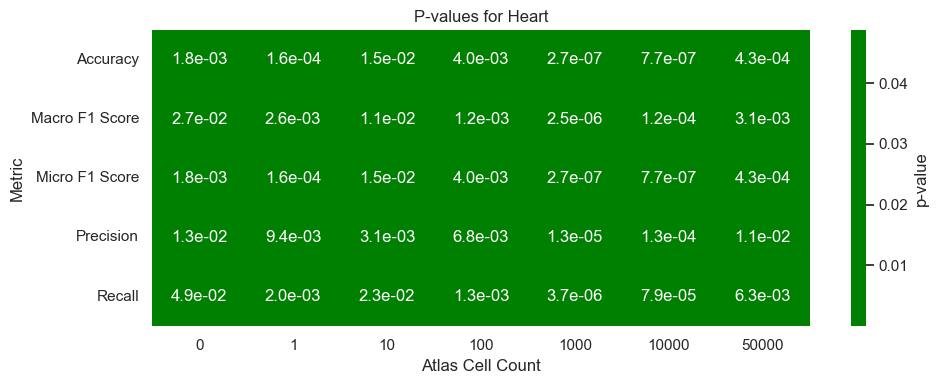

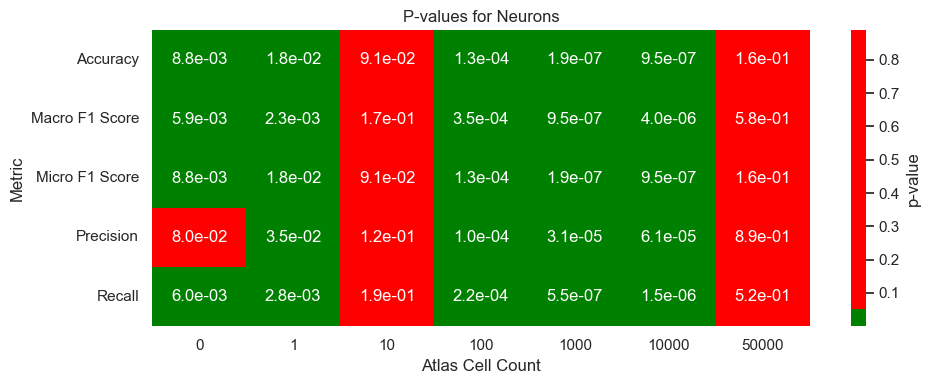

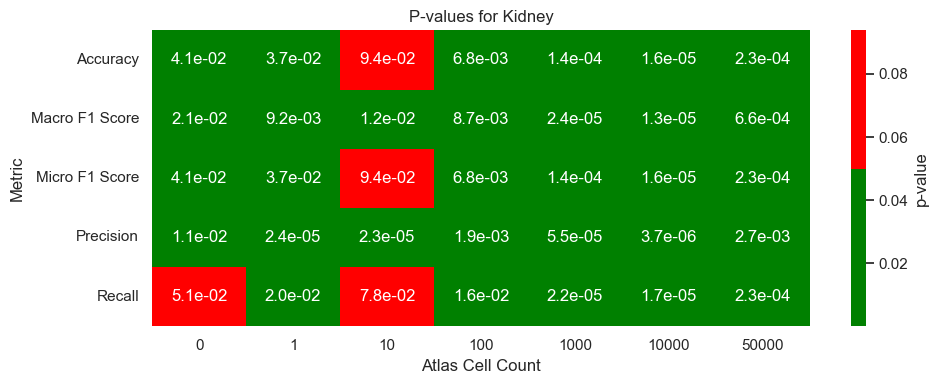

In [125]:
# convert results to a dataframe
results_df = pd.DataFrame(results)
results_df.columns = ['dataset', 'metric', 'Atlas_cell_count', 'p_value']

# plot results_df as a heatmap using seaborn for each dataset separately, with metric on the y-axis, Atlas_cell_count on the x-axis, and p-value < 0.05 light green and >= 0.05 light red, with annotated p-values in scientific notation
import seaborn as sns
import matplotlib.pyplot as plt

for dataset in results_df['dataset'].unique():
    pivot_df = results_df[results_df['dataset'] == dataset].pivot(index='metric', columns='Atlas_cell_count', values='p_value')
    plt.figure(figsize=(10, 4))
    sns.heatmap(pivot_df, annot=True, fmt=".1e", cmap=sns.color_palette(["green", "red"]), center=0.05, cbar_kws={'label': 'p-value'})
    plt.title(f'P-values for {dataset}')
    plt.ylabel('Metric')
    plt.xlabel('Atlas Cell Count')
    plt.tight_layout()
    plt.show()

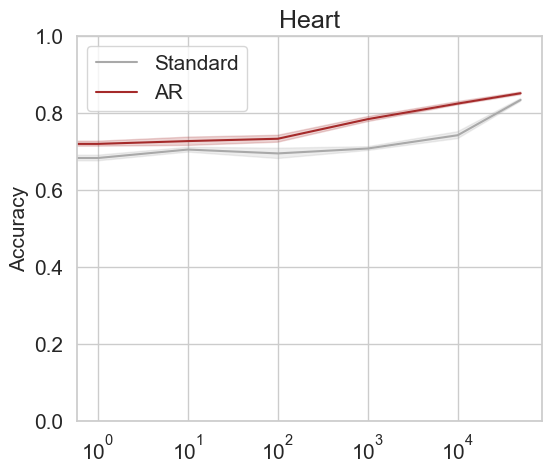

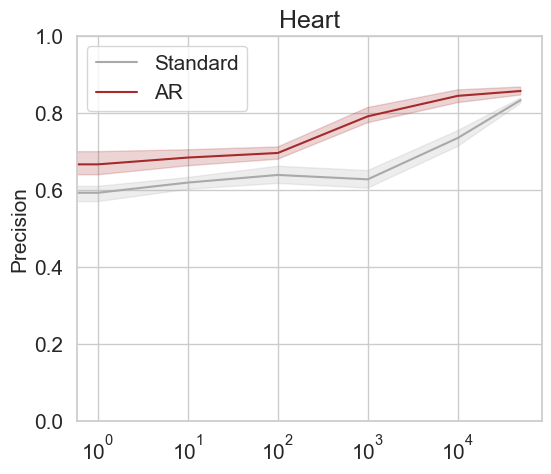

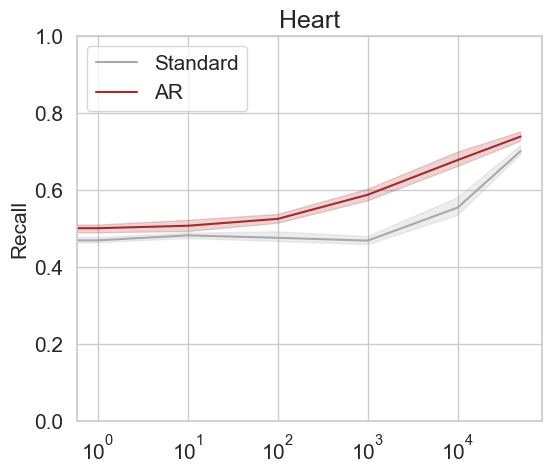

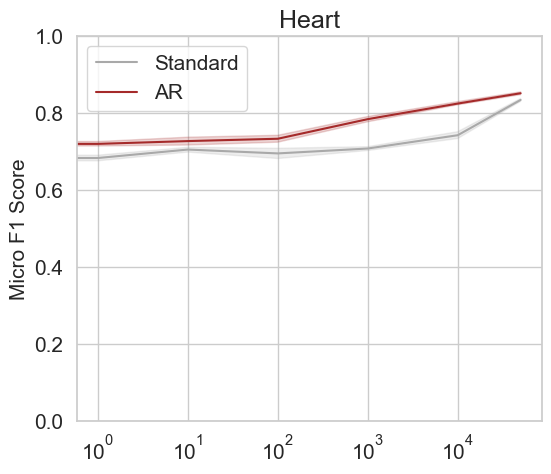

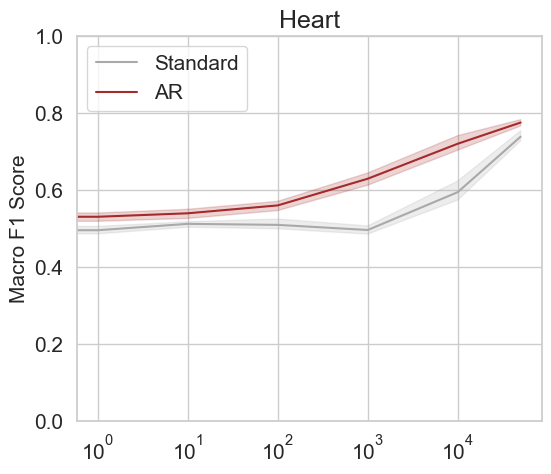

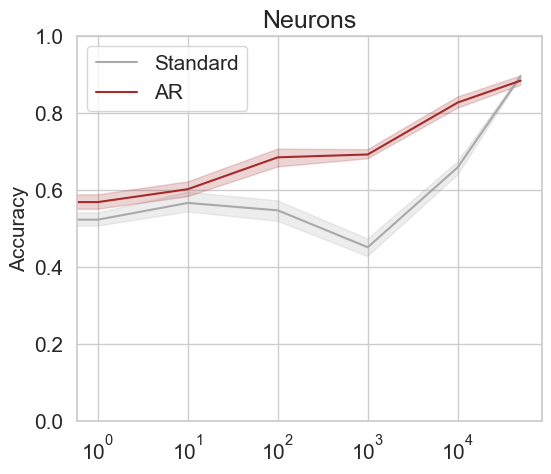

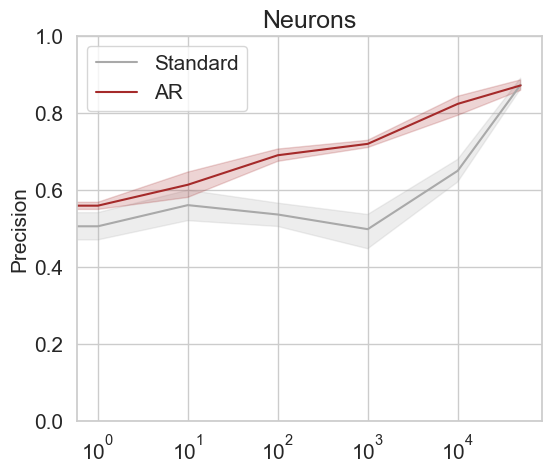

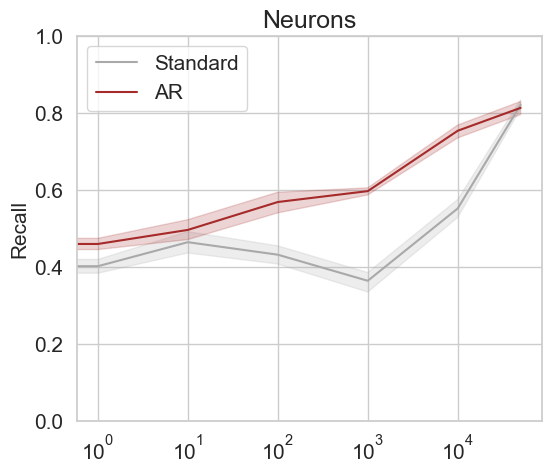

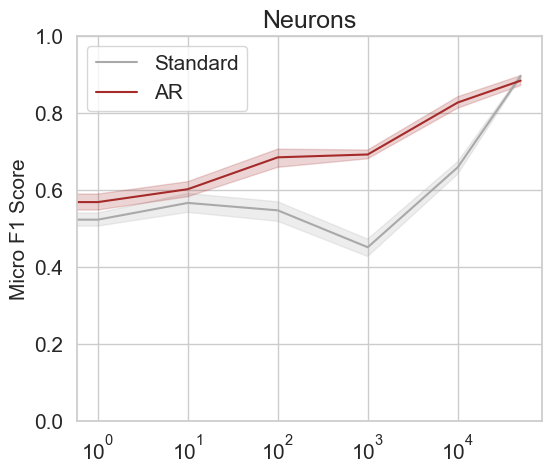

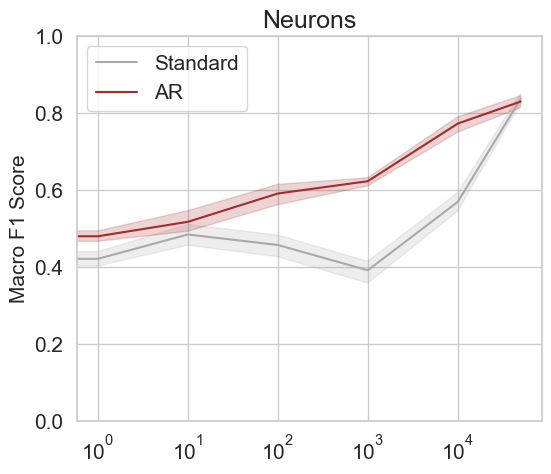

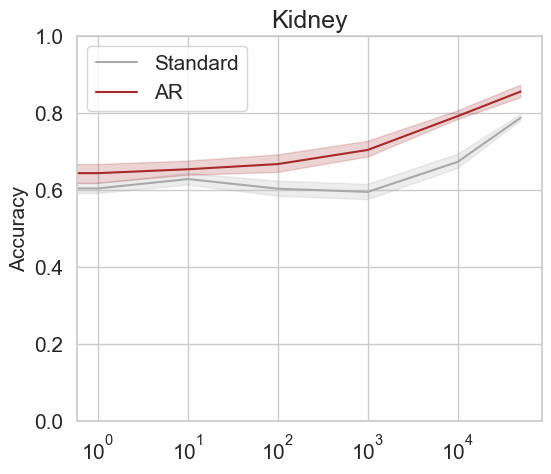

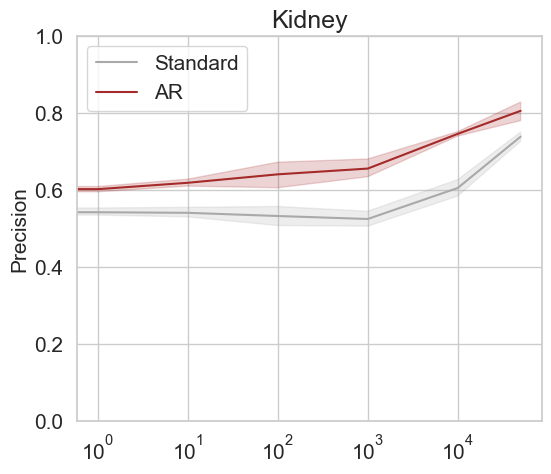

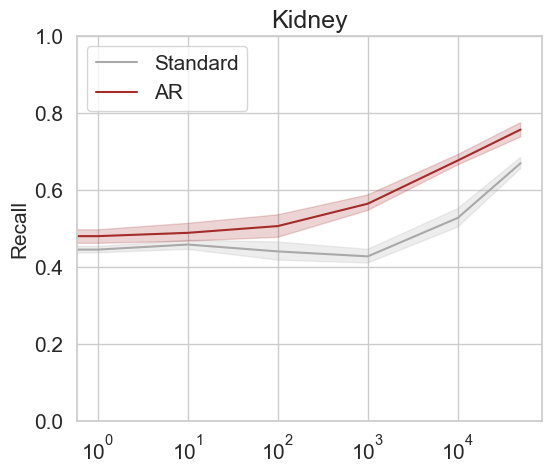

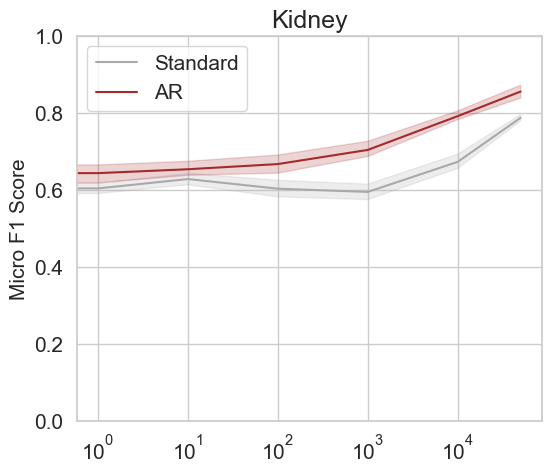

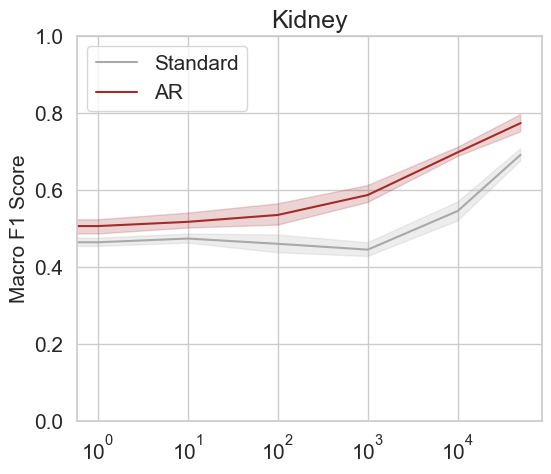

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt
# plot a group barplot for each dataset with metric in x-axis and value in y-axis, hue=AR_Type
palette = {'Standard':"darkgray",
           'AR':"brown"}
for dataset in plot_df['dataset'].unique():
    
    # loop through each metric
    for i, metric in enumerate(metrics):
        # create a new plot
        fig, axs = plt.subplots(1, 1, figsize=(6, 5))
        sns.set_theme(style="whitegrid")
        g = sns.lineplot(data=plot_df[(plot_df['dataset'] == dataset) & (plot_df['metric'] == metric)], 
                         x="Atlas_cell_count", y="value", hue="ARtype", palette=palette,
                         hue_order=['Standard', 'AR'])
        # set x and y labels
        g.set_xlabel('')
        g.set_ylabel(metric, fontsize=15)
        # set the title of the plot
        g.set_title(dataset.capitalize(), fontsize=18)
        # set the font size of the x and y ticks
        g.tick_params(axis='both', which='major', labelsize=15)
        g.tick_params(axis='both', which='minor', labelsize=15)
        g.legend(loc='upper left', fontsize=15)
        g.set(ylim=(0, 1))
        g.set_xscale("log", base=10)
        # save the plot with high resolution
        plt.savefig(f'../result/test/sctab/scvi_plots_manuscript/{dataset}_{metric}.png', dpi=600,
                    bbox_inches='tight')
        plt.show()


Generate plot for reconstruction error

In [1]:
import pickle
import os
import pandas as pd


df = pd.DataFrame(columns=['dataset', 'metric', 'value', 'ARtype', 'Atlas_cell_count', 'seed'])
dir ='../result/test/sctab/zeinab-reconstruction-evals-20250409-manuscript-version/'
# loop over all files inside dir and read the pickle files
for file in os.listdir(dir):
    if file.endswith(".pkl") and 'Reconstruction_seed_' in file:
        # print(file)
        
        # extract the dataset name, ARtype, seed and Atlas_cell_count from the file name
        ARtype = file.split('_')[4]
        seed = file.split('_')[2]
        Atlas_cell_count = file.split('_')[11]
        print('ARtype:', ARtype)
        print('seed:', seed)
        print('Atlas_cell_count:', Atlas_cell_count)
    
        # Open the pickle file in read-binary mode
        with open(dir+file, "rb") as f:
            data = pickle.load(f)
            print(list(data.keys()))
            dict_keys = list(data.keys())
            for key in dict_keys:
                test_df = data[key]
                print(test_df.columns)
                mean_r2 = test_df['r2'].mean()
                mean_corr = test_df['correlation'].mean()
                df.loc[len(df)] = [key, 'correlation', mean_corr, ARtype, Atlas_cell_count, seed]
                df.loc[len(df)] = [key, 'r2', mean_r2, ARtype, Atlas_cell_count, seed]


ARtype: T
seed: 46
Atlas_cell_count: 1000
['scTab_Heart_reconstruction', 'scTab_Kidney_reconstruction', 'Neurons_reconstruction']
Index(['correlation', 'r2', 'cell_type'], dtype='object')
Index(['correlation', 'r2', 'cell_type'], dtype='object')
Index(['correlation', 'r2', 'supercluster_term'], dtype='object')
ARtype: F
seed: 45
Atlas_cell_count: 50000
['scTab_Heart_reconstruction', 'scTab_Kidney_reconstruction', 'Neurons_reconstruction']
Index(['correlation', 'r2', 'cell_type'], dtype='object')
Index(['correlation', 'r2', 'cell_type'], dtype='object')
Index(['correlation', 'r2', 'supercluster_term'], dtype='object')
ARtype: T
seed: 43
Atlas_cell_count: 10
['scTab_Heart_reconstruction', 'scTab_Kidney_reconstruction', 'Neurons_reconstruction']
Index(['correlation', 'r2', 'cell_type'], dtype='object')
Index(['correlation', 'r2', 'cell_type'], dtype='object')
Index(['correlation', 'r2', 'supercluster_term'], dtype='object')
ARtype: T
seed: 45
Atlas_cell_count: 1000
['scTab_Heart_reconstru

In [2]:
# include only rows with seed in [42, 43, 44, 45, 46]
df = df[df['seed'].isin(['42', '43', '44', '45', '46'])]
print(df[df['ARtype'] == 'T'].shape[0])
print(df[df['ARtype'] == 'F'].shape[0])

print('df[df[seed] == 42].shape[0]:', df[df['seed'] == '42'].shape[0])
print('df[df[seed] == 43].shape[0]:', df[df['seed'] == '43'].shape[0])
print('df[df[seed] == 44].shape[0]:', df[df['seed'] == '44'].shape[0])
print('df[df[seed] == 45].shape[0]:', df[df['seed'] == '45'].shape[0])
print('df[df[seed] == 46].shape[0]:', df[df['seed'] == '46'].shape[0])

# print the number of rows for each Atlas_cell_count
print('Atlas_cell_count:', df['Atlas_cell_count'].unique())
# print the number of rows for each Atlas_cell_count=0,1,10,100,1000,10000,50000
print('Atlas_cell_count=0:', df[df['Atlas_cell_count'] == '0'].shape[0])
print('Atlas_cell_count=1:', df[df['Atlas_cell_count'] == '1'].shape[0])
print('Atlas_cell_count=10:', df[df['Atlas_cell_count'] == '10'].shape[0])
print('Atlas_cell_count=100:', df[df['Atlas_cell_count'] == '100'].shape[0])
print('Atlas_cell_count=1000:', df[df['Atlas_cell_count'] == '1000'].shape[0])
print('Atlas_cell_count=10000:', df[df['Atlas_cell_count'] == '10000'].shape[0])
print('Atlas_cell_count=50000:', df[df['Atlas_cell_count'] == '50000'].shape[0])


assert df[df['ARtype'] == 'T'].shape[0] == df[df['ARtype'] == 'F'].shape[0]
# assert if the number of rows for each seed is the same
assert df[df['seed'] == '42'].shape[0] \
    == df[df['seed'] == '43'].shape[0] \
    == df[df['seed'] == '44'].shape[0] \
    == df[df['seed'] == '45'].shape[0] \
    == df[df['seed'] == '46'].shape[0] 
    
df.shape

210
210
df[df[seed] == 42].shape[0]: 84
df[df[seed] == 43].shape[0]: 84
df[df[seed] == 44].shape[0]: 84
df[df[seed] == 45].shape[0]: 84
df[df[seed] == 46].shape[0]: 84
Atlas_cell_count: ['1000' '50000' '10' '1' '0' '100' '10000']
Atlas_cell_count=0: 60
Atlas_cell_count=1: 60
Atlas_cell_count=10: 60
Atlas_cell_count=100: 60
Atlas_cell_count=1000: 60
Atlas_cell_count=10000: 60
Atlas_cell_count=50000: 60


(420, 6)

In [3]:
# if 'heart' in df.dataset.lower, change it to 'Heart', if 'kidney' in df.dataset.lower, change it to 'Kidney'
df['dataset'] = df['dataset'].apply(lambda x: 'Heart' if 'heart' in x.lower() else x)
df['dataset'] = df['dataset'].apply(lambda x: 'Kidney' if 'kidney' in x.lower() else x)
df['dataset'] = df['dataset'].apply(lambda x: 'Neurons' if x=='Neurons_reconstruction' else x)

In [4]:
# replace ARtype with Standard
df['ARtype'] = df['ARtype'].apply(lambda x: 'Standard' if x == 'F' else 'AR')

In [5]:
# write a piece of code that for each dataset, metric and Atlas_cell_count, it calculated the p-value between AR and Naive using t-test
from scipy import stats
results = []

for dataset in df['dataset'].unique():
    for metric in df['metric'].unique():
        for atlas_cell_count in df['Atlas_cell_count'].unique():
            ar_values = df[(df['dataset'] == dataset) & 
                                (df['metric'] == metric) & 
                                (df['Atlas_cell_count'] == atlas_cell_count) & 
                                (df['ARtype'] == 'AR')]['value']
            naive_values = df[(df['dataset'] == dataset) & 
                                   (df['metric'] == metric) & 
                                   (df['Atlas_cell_count'] == atlas_cell_count) & 
                                   (df['ARtype'] == 'Standard')]['value']
            if len(ar_values) > 1 and len(naive_values) > 1:
                t_stat, p_value = stats.ttest_ind(ar_values, naive_values)
                results.append([dataset, metric, atlas_cell_count, p_value])
            else:
                results.append([dataset, metric, atlas_cell_count, None])

In [6]:
# convert results to a dataframe
results_df = pd.DataFrame(results)
results_df.columns = ['dataset', 'metric', 'Atlas_cell_count', 'p_value']
print('shape of results_df:', results_df.shape)
results_df

shape of results_df: (42, 4)


,dataset,metric,Atlas_cell_count,p_value
0,Heart,correlation,1000,2.013934e-07
1,Heart,correlation,50000,2.454040e-06
2,Heart,correlation,10,4.275485e-05
3,Heart,correlation,1,3.971956e-05
4,Heart,correlation,0,2.078610e-05
5,Heart,correlation,100,3.938781e-09
6,Heart,correlation,10000,2.183512e-11
7,Heart,r2,1000,8.288176e-07
8,Heart,r2,50000,1.493049e-06
9,Heart,r2,10,1.255784e-04


In [7]:
# print the latex table of results_df, with dataset in caption, colored by their p-value (green for p<0.05, yellow for p>=0.05)
for dataset in results_df['dataset'].unique():
    subset = results_df[results_df['dataset'] == dataset]
    pivot_table = subset.pivot(index='metric', columns='Atlas_cell_count', values='p_value')
    def color_pval(val):
        if pd.isna(val):
            return ''
        elif val < 0.05:
            return 'background-color: green; color: white;'
        else:
            return 'background-color: yellow; color: black;'
    styled_table = pivot_table.style.applymap(color_pval).format(precision=2, formatter="{:.2e}")
    latex_table = styled_table.to_latex(caption=f'P-values for {dataset}', label=f'tab:pvalues_{dataset}')
    print(latex_table)

\begin{table}
\caption{P-values for Heart}
\label{tab:pvalues_Heart}
\begin{tabular}{lrrrrrrr}
Atlas_cell_count & 0 & 1 & 10 & 100 & 1000 & 10000 & 50000 \\
metric &  &  &  &  &  &  &  \\
correlation & \background-colorgreen \colorwhite 2.08e-05 & \background-colorgreen \colorwhite 3.97e-05 & \background-colorgreen \colorwhite 4.28e-05 & \background-colorgreen \colorwhite 3.94e-09 & \background-colorgreen \colorwhite 2.01e-07 & \background-colorgreen \colorwhite 2.18e-11 & \background-colorgreen \colorwhite 2.45e-06 \\
r2 & \background-colorgreen \colorwhite 3.27e-04 & \background-colorgreen \colorwhite 3.56e-04 & \background-colorgreen \colorwhite 1.26e-04 & \background-colorgreen \colorwhite 9.91e-08 & \background-colorgreen \colorwhite 8.29e-07 & \background-colorgreen \colorwhite 7.25e-12 & \background-colorgreen \colorwhite 1.49e-06 \\
\end{tabular}
\end{table}

\begin{table}
\caption{P-values for Kidney}
\label{tab:pvalues_Kidney}
\begin{tabular}{lrrrrrrr}
Atlas_cell_count & 0 & 

/var/folders/ct/rqgms94d3k9_mbqkrnng_f7h0000gn/T/ipykernel_35662/63112505.py:12: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_table = pivot_table.style.applymap(color_pval).format(precision=2, formatter="{:.2e}")
/var/folders/ct/rqgms94d3k9_mbqkrnng_f7h0000gn/T/ipykernel_35662/63112505.py:12: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_table = pivot_table.style.applymap(color_pval).format(precision=2, formatter="{:.2e}")
/var/folders/ct/rqgms94d3k9_mbqkrnng_f7h0000gn/T/ipykernel_35662/63112505.py:12: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_table = pivot_table.style.applymap(color_pval).format(precision=2, formatter="{:.2e}")


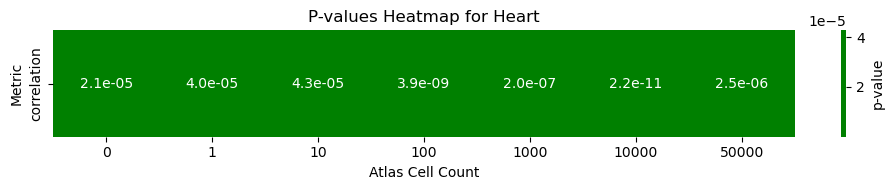

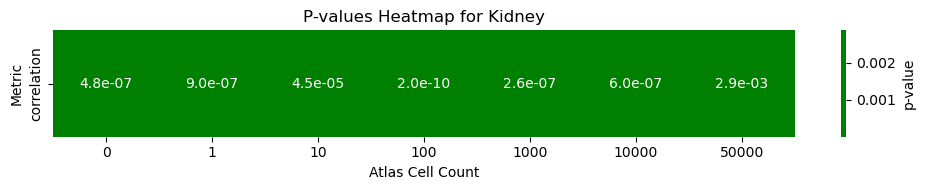

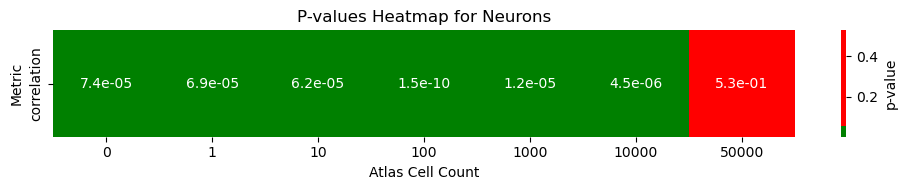

In [8]:

# plot heatmap of p-values for each dataset, where x axis is Atlas_cell_count, y axis is metric, and color is green if p-value < 0.05 else red
import seaborn as sns
import matplotlib.pyplot as plt
results_df = results_df[results_df['metric'].isin(['correlation'])]
for dataset in results_df['dataset'].unique():
    pivot_df = results_df[results_df['dataset'] == dataset].pivot(index='metric', columns='Atlas_cell_count', values='p_value')
    plt.figure(figsize=(10, 2))
    sns.heatmap(pivot_df, annot=True, fmt=".1e", cmap=sns.color_palette(["green", "red"]), center=0.05, cbar_kws={'label': 'p-value'})
    plt.title(f'P-values Heatmap for {dataset}')
    plt.xlabel('Atlas Cell Count')
    plt.ylabel('Metric')
    plt.axhline(y=-0.5, color='black', linewidth=2)  # Horizontal line at the top
    plt.axvline(x=-0.5, color='black', linewidth=2)  # Vertical line at the left
    plt.tight_layout()
    plt.show()


/var/folders/ct/rqgms94d3k9_mbqkrnng_f7h0000gn/T/ipykernel_35662/4120915056.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), horizontalalignment='right')


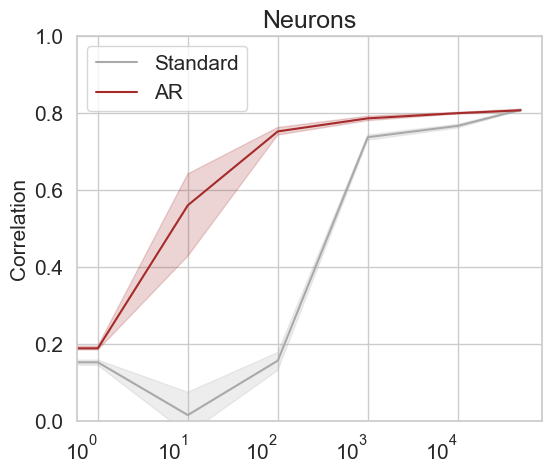

/var/folders/ct/rqgms94d3k9_mbqkrnng_f7h0000gn/T/ipykernel_35662/4120915056.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), horizontalalignment='right')


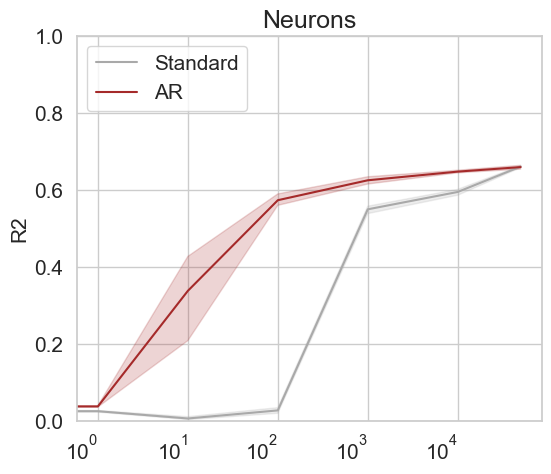

/var/folders/ct/rqgms94d3k9_mbqkrnng_f7h0000gn/T/ipykernel_35662/4120915056.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), horizontalalignment='right')


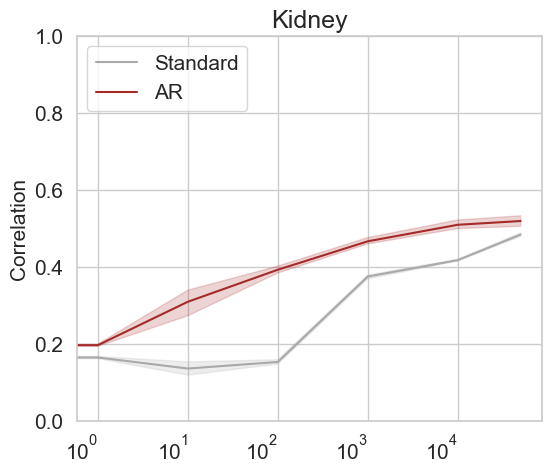

/var/folders/ct/rqgms94d3k9_mbqkrnng_f7h0000gn/T/ipykernel_35662/4120915056.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), horizontalalignment='right')


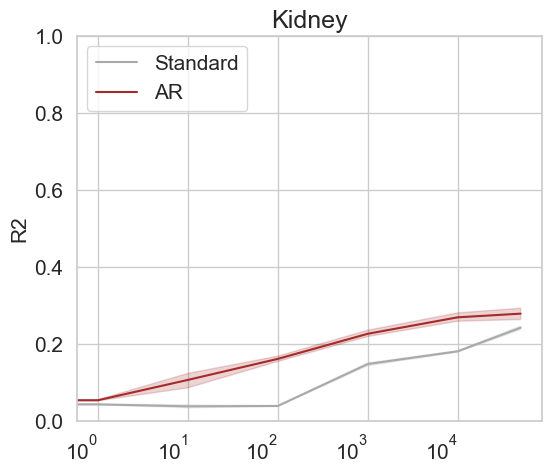

/var/folders/ct/rqgms94d3k9_mbqkrnng_f7h0000gn/T/ipykernel_35662/4120915056.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), horizontalalignment='right')


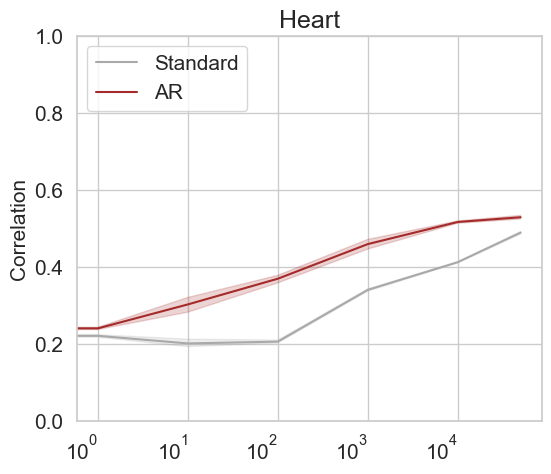

/var/folders/ct/rqgms94d3k9_mbqkrnng_f7h0000gn/T/ipykernel_35662/4120915056.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), horizontalalignment='right')


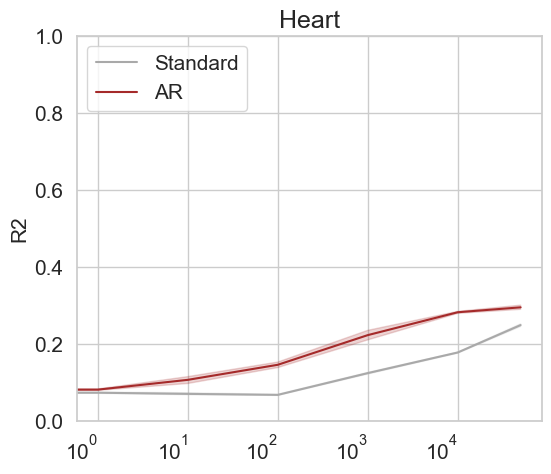

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot group barplot with Atlas_cell_count in x-axis, value in y-axis, hue=ARtype
# convert Atlas_cell_count to log scale

# convert the Atlas_cell_count label into int format
df['Atlas_cell_count'] = df['Atlas_cell_count'].astype(int)
# sort based on Atlas_cell_count
df = df.sort_values(by='Atlas_cell_count')

# plot a group barplot for each dataset with metric in x-axis and value in y-axis, hue=AR_Type
palette = {'Standard':"darkgray",
           'AR':"brown"}

for dataset in df['dataset'].unique():
    # loop through each metric
    for i, metric in enumerate(['correlation', 'r2']):
        fig, axs = plt.subplots(1, 1, figsize=(6, 5))
        sns.set_theme(style="whitegrid")
        g = sns.lineplot(data=df[(df['dataset'] == dataset) & (df['metric'] == metric)], 
                         x="Atlas_cell_count", y="value", hue="ARtype", palette=palette,
                         hue_order=['Standard', 'AR'])
        # set x and y labels
        g.set_xticklabels(g.get_xticklabels(), horizontalalignment='right')
        g.set_xlabel('')
        g.set_ylabel(metric.capitalize(), fontsize=15)
        g.set_title(dataset.capitalize(), fontsize=18)
        g.tick_params(axis='both', which='major', labelsize=15)
        g.tick_params(axis='both', which='minor', labelsize=15)
        g.set_xscale("log", base=10)
        g.legend(loc='upper left', fontsize=15)
        g.set(ylim=(0,1))
        
        # save the plot with high resolution
        plt.savefig(f'../result/test/sctab/scvi_plots_manuscript/{dataset}_{metric}.png', dpi=600,
                    bbox_inches='tight')
        plt.show()
        
        